In [1]:
'''
Summary In this assignment you will implement a new named entity recognition system using Hidden
Markov Models. You will begin by going through some multiple choice warm-up problems to build your
intuition for these models and then use that intuition to build your own HMM models.
'''

'\nSummary In this assignment you will implement a new named entity recognition system using Hidden\nMarkov Models. You will begin by going through some multiple choice warm-up problems to build your\nintuition for these models and then use that intuition to build your own HMM models.\n'

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import pandas as pd
import matplotlib.pyplot as plt  
import numpy as np
import csv
import sys
import random
from random import seed
from random import randint
from sklearn.metrics import accuracy_score
from bs4 import BeautifulSoup
from random import randrange
from scipy.special import expit
from scipy.special import softmax

np.set_printoptions(precision=10)
pd.option_context('display.max_rows', None, 'display.max_columns', None)  # more options can be specified also
np.set_printoptions(threshold=sys.maxsize)
seed(1)

np.set_printoptions(precision=10, )
pd.options.display.float_format = '{:.2f}'.format

%precision 10
!cp -r /content/drive/MyDrive/10601_DataSets /content

In [4]:
def Print_DF(df):
  with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
    print(df)

def read_csv_files(path):
  df_read = pd.read_csv(path, quoting=csv.QUOTE_NONE, encoding='utf-8', sep='\n', header=None, keep_default_na=False)
  print("Data shape: ", df_read.shape)
  df_read = df_read[0].str.split(' ', expand=True)

  return df_read

def Get_Words_Tags_DFs(df):
  words = pd.DataFrame()
  tags = pd.DataFrame()

  for i in df.columns:
    tmp = df[i].str.split('_', expand=True)
    if tmp.shape[1] == 1:
      continue
    words = pd.concat([words, tmp[0]], axis = 1, ignore_index=True)
    tags = pd.concat([tags, tmp[1]], axis = 1, ignore_index=True)

  return words, tags

In [5]:
large_train = read_csv_files('/content/10601_DataSets/HW7/fulldata/trainwords.txt')
large_test = read_csv_files('/content/10601_DataSets/HW7/fulldata/testwords.txt')
index_to_word = read_csv_files('/content/10601_DataSets/HW7/fulldata/index_to_word.txt')
index_to_tag = read_csv_files('/content/10601_DataSets/HW7/fulldata/index_to_tag.txt')

train_words, train_tags = Get_Words_Tags_DFs(large_train)
test_words, test_tags = Get_Words_Tags_DFs(large_test)

Data shape:  (14041, 1)
Data shape:  (3250, 1)
Data shape:  (8127, 1)
Data shape:  (9, 1)


In [6]:
def replace_tag_with_index(df_tags, df_total_tags):
  first = 1
  for index, row in df_total_tags.iterrows():
    if first == 1:
      df = df_tags.replace(row[0], index)
      first = 0
    else:
      df = df.replace(row[0], index)

  return df

In [7]:
tmp = index_to_word.to_dict()[0]
dict_of_words = dict((y,x) for x,y in tmp.items())
tmp = index_to_tag.to_dict()[0]
dict_of_tags = dict((y,x) for x,y in tmp.items())

In [8]:
def states_from_words_to_numbers(states, Dict_Of_Tags):
  states_alter = {}
  for key in states:
    from_state, to_state = key.split('_')
    num1 = Dict_Of_Tags[from_state]
    num2 = Dict_Of_Tags[to_state]
    key_new = str(num1) + '_' + str(num2)
    states_alter[key_new] = states[key]
  return states_alter

In [9]:
def Learn_HMM_Priors(df_tags, df_total_tags, Dict_Of_Tags):
  state_in_first_word = {}
  priors = {}

  # Loop over all tags in the 1st words in all training examples
  for tag in df_tags:
    tag_value = Dict_Of_Tags.get(tag, 0)
    # Get Number of times a state is associated with the 1st word and increase by 1
    state_in_first_word[tag_value] = state_in_first_word.get(tag_value, 0) + 1

  # Get the denominator for prior equation
  denominator = sum(state_in_first_word.values()) + len(Dict_Of_Tags)

  # Loop over all tags available in the model
  for tag in Dict_Of_Tags:
    tag_value = Dict_Of_Tags[tag]
    # Get Number of times a state is associated with the 1st word
    Num = state_in_first_word.get(tag_value, 0)
    # Apply prior equation from MLE 
    priors[tag_value] = (Num + 1) / (denominator)

  return np.fromiter(priors.values(), dtype=float)

In [10]:
def Learn_HMM_Transition(df_tags, Dict_Of_Tags):
  state_transition = {}

  # Get total number of tags in the system
  k = len(Dict_Of_Tags)

  transition_matrix = np.zeros((k, k))

  for index, row in df_tags.iterrows():
    for tag in range(len(row) - 1):
      # None isn't removed from dataset.
      if(row[tag] == None):
        break
      
      if row[tag+1] == None:
        continue
      
      key = row[tag] + '_' + row[tag+1]

      state_transition[key] = state_transition.get(key, 0) + 1

  transitions = states_from_words_to_numbers(state_transition, Dict_Of_Tags)

  denominator = 0
  
  for i in range(k):
    denominator = 0
    # Calculate the denominator
    for j in range(k):
      key = str(i) + '_' + str(j)
      denominator += transitions.get(key, 0)
    
    denominator += k

    for j in range(k):
      key = str(i) + '_' + str(j)
      value = transitions.get(key, 0)
      a_ij = (value + 1) / denominator
      transition_matrix[i][j] = a_ij

  return transition_matrix

In [11]:
def Learn_HMM_Emissions(df_train, Dict_Of_Tags, Dict_Of_Words):
  states_word_counts_dict = df_train.stack().value_counts().to_dict()
  states_count = {}
  words_states_count_enumerated = {}

  for key in states_word_counts_dict:
    word, state = key.split('_')
    if word == None:
      continue
    count = states_word_counts_dict[key]
    state = Dict_Of_Tags[state]
    word = Dict_Of_Words[word]
    new_key = str(word) + '_' + str(state)

    words_states_count_enumerated[new_key] = count
    states_count[state] = states_count.get(state, 0) + count

  number_of_states = len(Dict_Of_Tags)
  number_of_words = len(Dict_Of_Words)

  emission_matrix = np.zeros((number_of_states, number_of_words))

  for i in range(number_of_states):
    for j in range(number_of_words):
      key = str(j) + '_' + str(i) 
      count =  words_states_count_enumerated.get(key, 0) + 1
      denominator = states_count[i]
      b_ij = count / (denominator + number_of_words)
      emission_matrix[i][j] = b_ij

  return emission_matrix

In [12]:
def Learn_HMM_Parameters(total_states_words_df, df_words, df_tags, df_Ind2Tag, Dict_Of_Tags, Dict_Of_Words):
  '''
  This function implements an algorithm to learn 
  the hidden markov model parameters needed to apply 
  the forward backward algorithm. It estimates 3 sets of parameters:
  1. The initialization probabilities (pi)
  2. Transition probabilities (A)
  3. Emission probabilities (B)
  Each of these probabilities are modeled useing multinomial and the estimation
  is done using Maximum likelihood estimation.
  Equations used:
  1. P(y_1 = state j) = pi_j.
  2. P(y_t = state_k | y_t-1 = state_j) = ajk
  3. P(xt = kjyt = j) = bjk
  '''
  # Send 1st word's tag and all of model tags to calculate prior probabilities
  priors = Learn_HMM_Priors(df_tags[0], df_Ind2Tag[0], Dict_Of_Tags)
  print("Prior matrix Sanity check: ", priors.sum(axis=0))
  
  # Get transition matrix
  transitions = Learn_HMM_Transition(df_tags, Dict_Of_Tags)
  print("Transitions matrix Sanity check: ", transitions.sum(axis=1))

  # Get emission matrix
  emissions = Learn_HMM_Emissions(total_states_words_df, Dict_Of_Tags, Dict_Of_Words)
  print("Emission matrix Sanity check: ", emissions.sum(axis=1))

  return priors, transitions, emissions

In [14]:
def LOGSUMEXP(x, y):
  if x == float("-inf"):
    return y
  if y == float("-inf"):
    return x
  
  m = 0.0
  mm = 0.0
  if x >= y:
    m = x
    mm = y
  else:
    m = y
    mm = x

  return m + np.log(1 + np.exp(mm - m))

In [15]:
def forward_algorithm(example, Emission, Transition, Prior, Dict_Of_Tags, Dict_Of_Words):

  number_of_states = len(Dict_Of_Tags)
 
  WORDS_index = []

  for word in example:
    if(word == None):
      break
    # Save the current word index
    WORDS_index.append(Dict_Of_Words[word])

  num_example_words = len(WORDS_index)  

  # Alpha matrix is (Distinct_words_count x Distinct_states_count)
  alpha_mat = np.zeros((num_example_words, number_of_states))

  # Moving along words in the example
  for word in range(num_example_words):
    # Move along all states 
    for state in range(number_of_states):
      if word == 0:
        alpha_mat[word][state] = np.log(Prior[state]) + np.log(Emission[state][WORDS_index[word]])

      else:
        summation_term = np.float64(0.0)
        word_prev = word - 1

        for state_iter in range(number_of_states):
          tmp = alpha_mat[word_prev][state_iter] + np.log(Transition[state_iter][state])
          if state_iter == 0:
            summation_term = tmp
          else:
            summation_term = LOGSUMEXP(summation_term, tmp)

        alpha_mat[word][state] = np.log(Emission[state][WORDS_index[word]]) + summation_term

  return alpha_mat

In [16]:
def backward_algorithm(example, Emission, Transition, Prior, Dict_Of_Tags, Dict_Of_Words):

  number_of_states = len(Dict_Of_Tags)
 
  WORDS_index = []

  for word in example:
    if(word == None):
      break
    # Save the current word index
    WORDS_index.append(Dict_Of_Words[word])

  num_example_words = len(WORDS_index)  

  # Alpha matrix is (Distinct_words_count x Distinct_states_count)
  beta_mat = np.zeros((num_example_words, number_of_states))

  # Reverse words so that we start from the end and work the way back to the first word
  WORDS_index.reverse()

  # Moving along words in the example
  for word in range(num_example_words):
    # Move along all states 
    for state in range(number_of_states):
      if word == 0:
        # nitialize all states in this case to 1 only
        beta_mat[word][state] = np.log(1)

      else:
        summation_term = np.float64(0.0)
        word_prev = word - 1

        for state_iter in range(number_of_states):
          tmp = np.log(Emission[state_iter][WORDS_index[word]]) + beta_mat[word_prev][state_iter] + np.log(Transition[state][state_iter])
          
          if state_iter == 0:
            summation_term = tmp
          else:
            summation_term = LOGSUMEXP(summation_term, tmp)

        beta_mat[word][state] = summation_term
        
  return np.flipud(beta_mat)

In [24]:
from numpy import linalg as LA

def Forward_backward_algorithm(df_test, Emission, Transition, Prior, Dict_Of_Tags, Dict_Of_Words):
  
  test_output = ""
  log_likeli_hood = []

  for index, row in df_test.iterrows():
    alpha_mat = forward_algorithm(row, Emission, Transition, Prior, Dict_Of_Tags, Dict_Of_Words)
    beta_mat = backward_algorithm(row, Emission, Transition, Prior, Dict_Of_Tags, Dict_Of_Words)

    alpha_mat = np.exp(alpha_mat)
    beta_mat = np.exp(beta_mat)

    log_likeli_hood.append(np.log(np.sum(alpha_mat[-1])) / alpha_mat.shape[1]) 
    
    denomenator_mat = np.sum(np.multiply(alpha_mat, beta_mat), axis=1)
    gamma_mat = np.zeros((alpha_mat.shape[0], alpha_mat.shape[1]))

    NumOfWordsinExample = alpha_mat.shape[0] 
    NumOfStates = alpha_mat.shape[1] 

    for word in range(NumOfWordsinExample):
      for state in range(NumOfStates):
        gamma_mat[word][state] = alpha_mat[word][state] * beta_mat[word][state] / denomenator_mat[word]
    
    for i in range(NumOfWordsinExample):
      index_of_max_probability = np.argmax(gamma_mat[i])

      value = list(Dict_Of_Tags.keys())[list(Dict_Of_Tags.values()).index(index_of_max_probability)]
      test_output += row[i] + '_' + value + ' '

    test_output += "\n"  
  
  with open('predictedtest.txt', 'w') as f:
    f.write(test_output)

  return np.sum(np.array(log_likeli_hood) / df_test.shape[0])

In [27]:
def Run_HMM(train_df, Train_Words, train_tags, test_df,
            Index_To_Tag, Dict_Of_Tags, Dict_Of_Words):

  p_mat, t_mat, e_mat = Learn_HMM_Parameters(train_df, Train_Words, 
                                                                 train_tags, Index_To_Tag, 
                                                                 Dict_Of_Tags, Dict_Of_Words)
  
  ll =  Forward_backward_algorithm(test_df, e_mat, t_mat, p_mat, Dict_Of_Tags, Dict_Of_Words)
  print("Average log likelihood: ", ll)

  return ll

In [46]:
large_train = read_csv_files('/content/10601_DataSets/HW7/fulldata/trainwords.txt')
large_test = read_csv_files('/content/10601_DataSets/HW7/fulldata/testwords.txt')
index_to_word = read_csv_files('/content/10601_DataSets/HW7/fulldata/index_to_word.txt')
index_to_tag = read_csv_files('/content/10601_DataSets/HW7/fulldata/index_to_tag.txt')

test_ll = []
train_ll = []

train_words, train_tags = Get_Words_Tags_DFs(pd.DataFrame(large_train[:10]))
test_words, test_tags = Get_Words_Tags_DFs(large_test[:10])
test_ll.append(Run_HMM(large_train, train_words, train_tags, test_words,
              index_to_tag, dict_of_tags, dict_of_words))
train_ll.append(Run_HMM(large_train, train_words, train_tags, train_words,
               index_to_tag, dict_of_tags, dict_of_words))

print()
train_words, train_tags = Get_Words_Tags_DFs(large_train[:1000])
test_words, test_tags = Get_Words_Tags_DFs(large_test[:1000])
test_ll.append(Run_HMM(large_train, train_words, train_tags, test_words,
              index_to_tag, dict_of_tags, dict_of_words))
train_ll.append(Run_HMM(large_train, train_words, train_tags, train_words,
               index_to_tag, dict_of_tags, dict_of_words))

print()
train_words, train_tags = Get_Words_Tags_DFs(large_train[:3000])
test_words, test_tags = Get_Words_Tags_DFs(large_test[:3000])
test_ll.append(Run_HMM(large_train, train_words, train_tags, test_words,
              index_to_tag, dict_of_tags, dict_of_words))
train_ll.append(Run_HMM(large_train, train_words, train_tags, train_words,
               index_to_tag, dict_of_tags, dict_of_words))


print()
train_words, train_tags = Get_Words_Tags_DFs(large_train)
test_words, test_tags = Get_Words_Tags_DFs(large_test)
train_ll.append(Run_HMM(large_train, train_words, train_tags, train_words,
               index_to_tag, dict_of_tags, dict_of_words))
test_ll.append(Run_HMM(large_train, train_words, train_tags, test_words,
              index_to_tag, dict_of_tags, dict_of_words))

Data shape:  (14041, 1)
Data shape:  (3250, 1)
Data shape:  (8127, 1)
Data shape:  (9, 1)
Prior matrix Sanity check:  0.9999999999999999
Transitions matrix Sanity check:  [1. 1. 1. 1. 1. 1. 1. 1. 1.]
Emission matrix Sanity check:  [1. 1. 1. 1. 1. 1. 1. 1. 1.]
Average log likelihood:  -21.6886012290039
Prior matrix Sanity check:  0.9999999999999999
Transitions matrix Sanity check:  [1. 1. 1. 1. 1. 1. 1. 1. 1.]
Emission matrix Sanity check:  [1. 1. 1. 1. 1. 1. 1. 1. 1.]
Average log likelihood:  -18.364178934775975

Prior matrix Sanity check:  1.0
Transitions matrix Sanity check:  [1. 1. 1. 1. 1. 1. 1. 1. 1.]
Emission matrix Sanity check:  [1. 1. 1. 1. 1. 1. 1. 1. 1.]
Average log likelihood:  -9.819977425625897
Prior matrix Sanity check:  1.0
Transitions matrix Sanity check:  [1. 1. 1. 1. 1. 1. 1. 1. 1.]
Emission matrix Sanity check:  [1. 1. 1. 1. 1. 1. 1. 1. 1.]
Average log likelihood:  -8.853274152614468

Prior matrix Sanity check:  1.0
Transitions matrix Sanity check:  [1. 1. 1. 1. 1. 

<Figure size 432x288 with 0 Axes>

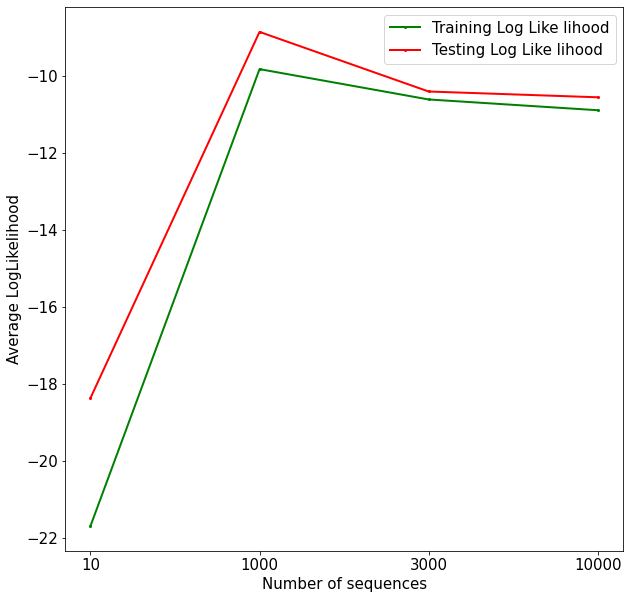

In [54]:
import numpy as np 
x = [10, 1000, 3000, 10000]
fig = plt.figure()
plt.figure(figsize=(10, 10))
plt.rcParams.update({'font.size': 15})
plt.ylabel('Average LogLikelihood')
plt.xlabel('Number of sequences')
plt.plot(test_ll, color='green', marker='o', linestyle='solid', linewidth=2, markersize=2, label = "Training Log Like lihood")
plt.plot(train_ll, color='red', marker='o', linestyle='solid', linewidth=2, markersize=2, label = "Testing Log Like lihood")
plt.xticks(range(len(x)), x)
plt.legend()